## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

## Import Tables

In [4]:
# Doug's Path
diagnoses_icd = pd.read_csv('data/mimic-iv-0.4/hosp/diagnoses_icd.csv.gz', compression='gzip')
d_icd_diagnoses = pd.read_csv('data/mimic-iv-0.4/hosp/d_icd_diagnoses.csv.gz', compression='gzip')
admissions = pd.read_csv('data/mimic-iv-0.4/core/admissions.csv.gz', compression='gzip')
pateints =  pd.read_csv('data/mimic-iv-0.4/core/patients.csv.gz', compression='gzip')
d_labitems = pd.read_csv('data/mimic-iv-0.4/hosp/d_labitems.csv.gz', compression='gzip')

# # Stephen's Path
# path = "D:\\Bootcamp\\MIMIC IV\\"
# admissions = pd.read_csv(path + "core\\admissions.csv.gz", compression='gzip')
# patients = pd.read_csv(path + "core\\patients.csv.gz", compression='gzip')
# diagnoses_icd = pd.read_csv(path + "hosp\\diagnoses_icd.csv.gz", compression='gzip')
# d_icd_diagnoses = pd.read_csv(path + "hosp\\d_icd_diagnoses.csv.gz", compression='gzip')
# d_labitems = pd.read_csv(path + "hosp\\d_labitems.csv.gz", compression='gzip')

## Pull codes related to Acute Kidney Failure

In [5]:
# Congestive Heart Failure
# chf_codes = list(map(str, d_icd_diagnoses[(d_icd_diagnoses['long_title'].str.lower().str.contains('congestive')) & (d_icd_diagnoses['long_title'].str.lower().str.contains('heart'))]['icd_code']))

kidney_list = list(d_icd_diagnoses[(d_icd_diagnoses['long_title'].str.lower().str.contains('kidney')) & (d_icd_diagnoses['long_title'].str.lower().str.contains('failure'))]['icd_code'])
pd.DataFrame(diagnoses_icd[diagnoses_icd['icd_code'].isin(kidney_list)].icd_code.value_counts()).reset_index().head(20).merge(d_icd_diagnoses, left_index = True, left_on = "index", right_on = 'icd_code', how = 'left')

# ICD Codes we care about
# 5849, N179, 5845, N170
akf_codes = ['5849   ', 'N179   ', '5845   ', 'N170   ']


## Start filtering down to only records where AKF is True

In [6]:
diagnoses_icd_akf = diagnoses_icd[diagnoses_icd['icd_code'].isin(akf_codes)]


In [7]:
diagnoses_icd_akf.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
76,19586042,23279761,2,5849,9
517,16108683,21607477,4,5845,9
537,14411859,24976204,12,5845,9
826,17752053,24437021,2,5849,9
893,16569548,24870770,5,5849,9


## Generate new Admissions table with hospital stay duration and AKF flag

In [8]:
admissions_akf = admissions[['subject_id', 'hadm_id', 'admittime', 'dischtime', 'ethnicity']]

admissions_akf['AKF_subj'] = np.where(admissions_akf.subject_id.isin(diagnoses_icd_akf.subject_id), 1, 0)
admissions_akf['AKF_adm'] = np.where(admissions_akf.hadm_id.isin(diagnoses_icd_akf.hadm_id), 1, 0)
admissions_akf['time_spent'] = pd.to_datetime(admissions_akf['dischtime']) - pd.to_datetime(admissions_akf['admittime'])


D:\Software\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Software\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Software\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [9]:
admissions_akf.head(10)

,subject_id,hadm_id,admittime,dischtime,ethnicity,AKF_subj,AKF_adm,time_spent
0,12427812,21593330,2184-01-06 11:51:00,2184-01-10 11:45:00,UNKNOWN,0,0,3 days 23:54:00
1,14029832,22059088,2120-01-18 01:28:00,2120-01-20 16:13:00,OTHER,0,0,2 days 14:45:00
2,14495017,22484010,2175-01-28 15:41:00,2175-01-29 16:00:00,WHITE,0,0,1 days 00:19:00
3,13676048,23865469,2193-01-19 05:27:00,2193-01-24 18:59:00,WHITE,0,0,5 days 13:32:00
4,13831972,27763544,2131-01-27 04:03:00,2131-01-27 05:39:00,WHITE,0,0,0 days 01:36:00
5,18523038,25414328,2142-08-26 17:14:00,2142-08-27 10:00:00,WHITE,0,0,0 days 16:46:00
6,16705931,20580522,2174-10-24 11:30:00,2174-10-24 18:45:00,WHITE,1,0,0 days 07:15:00
7,19963742,24951506,2171-07-04 15:58:00,2171-07-05 13:37:00,UNKNOWN,0,0,0 days 21:39:00
8,10903424,22568585,2181-01-31 13:09:00,2181-01-31 13:42:00,WHITE,0,0,0 days 00:33:00
9,15030422,21975876,2149-09-21 23:54:00,2149-09-22 03:59:00,WHITE,0,0,0 days 04:05:00


## Sample Target Patients for Modeling

In [18]:
n_samples = 15000

target_sample = admissions_akf[['subject_id', 'AKF_subj']].drop_duplicates()

target_sample = resample(target_sample, n_samples = n_samples, replace = False, stratify = target_sample.AKF_subj, random_state = 0)


Number of unique Patients:  15000

Sample Breakdown:
0    13269
1     1731
Name: AKF_subj, dtype: int64


In [19]:
# identify first akf visit for NON-AKF patients
sample_non = target_sample[target_sample.AKF_subj==0]
admissions_non = admissions[admissions.subject_id.isin(sample_non.subject_id)]
admissions_non['admittime'] = pd.to_datetime(admissions_non.admittime)
first_non = admissions_non.loc[admissions_non.groupby('subject_id').admittime.idxmin()]
# sanity checks
print(first_non.shape)                 # number of rows
print(first_non.subject_id.nunique())  # matches number of patients
print(first_non.hadm_id.nunique())     # matches number of visits

# pull out hospital visits for target non-akf samples
sample_non = sample_non.merge(first_non, how='inner', on='subject_id')
sample_non = sample_non[['subject_id', 'hadm_id', 'AKF_subj']]
sample_non = sample_non.rename({'AKF_subj':'AKF'}, axis=1)

D:\Software\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(13269, 15)
13269
13269


In [20]:
# identify first akf visit for all AKF patients
sample_akf = target_sample[target_sample.AKF_subj==1]
first_akf = admissions_akf[admissions_akf.subject_id.isin(sample_akf.subject_id)]
first_akf['admittime'] = pd.to_datetime(first_akf.admittime)
first_akf = first_akf.loc[first_akf[first_akf.AKF_adm==1].groupby('subject_id').admittime.idxmin()]
first_akf = first_akf[['subject_id', 'hadm_id', 'AKF_adm']]
# sanity checks
print(np.mean(first_akf.AKF_adm))   # make sure everyone has AKF
print(first_akf.shape)                 # make sure number of rows...
print(first_akf.subject_id.nunique())  # ...matches number of patients
print(first_akf.hadm_id.nunique())     # ...matches number of visits

# pull out hospital visits for target akf samples
sample_akf = sample_akf.merge(first_akf, how='inner', on='subject_id')
sample_akf = sample_akf[['subject_id', 'hadm_id', 'AKF_adm']]
sample_akf = sample_akf.rename({'AKF_adm':'AKF'}, axis=1)

D:\Software\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


1.0
(1731, 3)
1731
1731


In [21]:
# merge back together
admissions_sample = pd.concat([sample_akf, sample_non])
admissions_sample = admissions_sample.reset_index(drop=True)
print(admissions_sample.shape)                  # sanity check
print(admissions_sample.subject_id.nunique())   # sanity check

(15000, 3)
15000


In [22]:
# merge features from other tables
admissions_sample = admissions_sample.merge(admissions[['hadm_id', 'ethnicity']], how='left', on='hadm_id')
admissions_sample = admissions_sample.merge(patients[['subject_id', 'gender', 'anchor_age']], how='left', on='subject_id')

# basic data cleaning
admissions_sample.loc[admissions_sample.ethnicity=='UNABLE TO OBTAIN', 'ethnicity'] = 'UNKNOWN'  # combine unkown
admissions_sample = admissions_sample.rename(columns={'anchor_age':'age'})
admissions_sample = admissions_sample[admissions_sample.age > 0]   # remove children

Text(0.5, 1.0, 'Age Distribution')

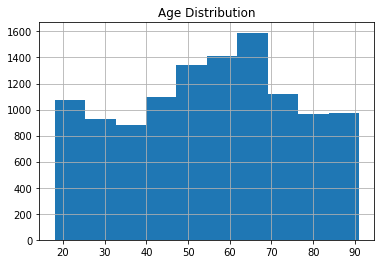

In [23]:
admissions_sample.age.hist()
plt.title('Age Distribution')

Text(0.5, 1.0, 'Gender Distribution')

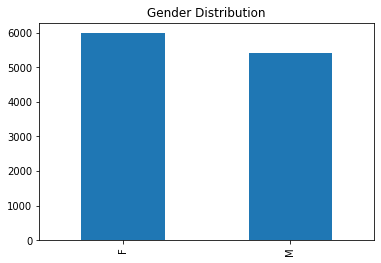

In [24]:
admissions_sample.gender.value_counts().plot(kind='bar')
plt.title('Gender Distribution')

Text(0.5, 1.0, 'Ethnicity Distribution')

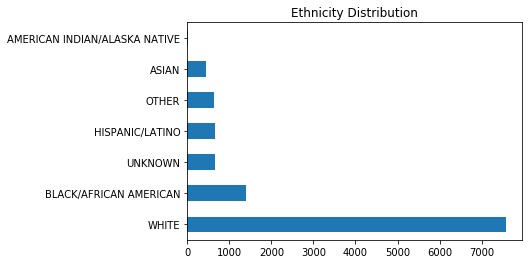

In [25]:
admissions_sample.ethnicity.value_counts().plot(kind='barh')
plt.title('Ethnicity Distribution')

In [27]:
print('Number of unique Patients: ', target_sample.subject_id.nunique())
print('\nSample Breakdown:')
print(target_sample.AKF_subj.value_counts())

Number of unique Patients:  15000

Sample Breakdown:
0    13269
1     1731
Name: AKF_subj, dtype: int64


Generate pickle file so we all work on the exact same data

In [28]:
admissions_sample.to_pickle('admissions_sample.pkl')

In [ ]:
# admissions_sample = pd.read_pickle("admissions_sample.pkl")

## Pull Chart and Lab data only where it matches our sample patient list

## We have Decided not to use Chart data after exploring it further

In [29]:
# %%time #run this for next time

# chunksize = 3*(10 ** 6)
# counter=0
# chartevents_sample = []
# for chunk in pd.read_csv('data/mimic-iv-0.4/icu/chartevents.csv.gz', compression='gzip', chunksize=chunksize):
#     chartevents_sample.append(chunk[chunk['subject_id'].isin(list(admissions_sample.subject_id))])
#     counter+=1
#     print(f'chunk {counter} processed')

# chartevents_final = pd.concat(chartevents_sample)


In [30]:
# chartevents_final.to_pickle("chartevents_final.pkl")

In [31]:
# chartevents_final = pd.read_pickle("chartevents_final.pkl")

In [32]:
# chartevents_final.shape

Load Lab Events table

In [33]:
%%time

chunksize = 3*(10 ** 6)
counter=0
lab_events_sample = []
for chunk in pd.read_csv('data/mimic-iv-0.4/hosp/labevents.csv.gz', compression='gzip', chunksize=chunksize):
    lab_events_sample.append(chunk[chunk['subject_id'].isin(list(admissions_sample.subject_id))])
    counter+=1
    print(f'chunk {counter} processed')

lab_events_final = pd.concat(lab_events_sample)
# 3min 52s


FileNotFoundError: [Errno 2] No such file or directory: 'data/mimic-iv-0.4/hosp/labevents.csv.gz'

In [34]:
# lab_events_final.to_pickle("lab_events_final.pkl")

In [35]:
lab_events_final = pd.read_pickle("lab_events_final.pkl")

In [36]:
lab_events_final.shape

(2337576, 15)

## Manipulating the Data

Take only records related to our sample patients

Filter lab events based on first hospital visit of our sample population

In [37]:
admissions_sample = pd.read_pickle("admissions_sample.pkl")

In [38]:
# lab_events_sampled = lab_events_final.copy()
%time lab_events_sampled = lab_events_final[lab_events_final['hadm_id'].isin(admissions_sample.hadm_id)]


Wall time: 682 ms


Check how many patients have had each test done

In [39]:
lab_events_sampled.groupby('itemid')['subject_id'].nunique().sort_values(ascending = False).head(10)

itemid
51221    2806
51265    2751
51222    2730
51301    2728
51277    2727
51279    2727
51248    2727
51250    2727
51249    2727
50912    2643
Name: subject_id, dtype: int64

Most common tests performed on patients with AKF

In [40]:
lab_events_sampled[lab_events_sampled['subject_id'].isin(list(admissions_sample[admissions_sample['AKF'] == 1].subject_id))].groupby('itemid')['subject_id'].nunique().sort_values(ascending = False).head(10)


itemid
50912    567
50971    566
51006    565
50902    565
50931    565
50983    565
50882    565
50868    565
51221    564
51279    563
Name: subject_id, dtype: int64

Item Black List

In [41]:
item_black_list = [50920]
# 50920 - test results are text in comments - need to come back and figure out how to handle this


Take only the X most commonly performed tests

In [42]:
top_test_num = 40

lab_events_valid = lab_events_sampled[~lab_events_sampled['itemid'].isin(item_black_list)]

# On patients with AKF
itemid_sub_sample = lab_events_valid[lab_events_valid['subject_id'].isin(list(admissions_sample[admissions_sample['AKF'] == 1].subject_id))].groupby('itemid')['subject_id'].nunique().sort_values(ascending = False).head(top_test_num).reset_index().rename(columns = {'index' : 'itemid'}).itemid.to_list()
# On all sample patients
# itemid_sub_sample = lab_events_sampled.groupby('itemid')['subject_id'].nunique().sort_values(ascending = False).head(top_test_num).reset_index().rename(columns = {'index' : 'itemid'}).itemid.to_list()

lab_events_sampled_sub = lab_events_sampled[lab_events_sampled['itemid'].isin(itemid_sub_sample)]
# lab_events_sampled_sub = lab_events_sampled[lab_events_sampled['itemid'].isin([51466])]

lab_events_sampled_sub


,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
1695,30338499,12455866,24494044.0,13622007,51221,2135-02-16 04:07:00,2135-02-16 04:50:00,34.7,34.7,%,34.0,45.0,NaN,ROUTINE,NaN
1696,30338500,12455866,24494044.0,13622007,51222,2135-02-16 04:07:00,2135-02-16 04:50:00,11.1,11.1,g/dL,11.2,15.7,abnormal,ROUTINE,NaN
1697,30338501,12455866,24494044.0,13622007,51248,2135-02-16 04:07:00,2135-02-16 04:50:00,31.4,31.4,pg,26.0,32.0,NaN,ROUTINE,NaN
1698,30338502,12455866,24494044.0,13622007,51249,2135-02-16 04:07:00,2135-02-16 04:50:00,32.0,32.0,g/dL,32.0,37.0,NaN,ROUTINE,NaN
1699,30338503,12455866,24494044.0,13622007,51250,2135-02-16 04:07:00,2135-02-16 04:50:00,98,98.0,fL,82.0,98.0,NaN,ROUTINE,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122202389,29500020,12390274,26496227.0,62980950,51274,2183-10-23 06:25:00,2183-10-23 08:14:00,23.5,23.5,sec,10.4,13.4,abnormal,ROUTINE,NaN
122202390,29500021,12390274,26496227.0,62980950,51275,2183-10-23 06:25:00,2183-10-23 08:14:00,94.6,94.6,sec,22.0,35.0,abnormal,ROUTINE,NaN
122202391,29500022,12390274,26496227.0,80463807,51237,2183-10-24 06:50:00,2183-10-24 08:44:00,2.5,2.5,NaN,0.9,1.1,abnormal,ROUTINE,NaN
122202392,29500023,12390274,26496227.0,80463807,51274,2183-10-24 06:50:00,2183-10-24 08:44:00,26.0,26.0,sec,10.4,13.4,abnormal,ROUTINE,NaN


In [43]:
lab_events_sampled_sub[lab_events_sampled_sub['itemid'] == 50920].comments.value_counts()

Series([], Name: comments, dtype: int64)

## Code to look into specific test values

In [44]:
# lab_events_sampled_sub.groupby(['subject_id', 'hadm_id', 'itemid']).count()


In [45]:
lab_events_sampled_sub_tiny = lab_events_sampled_sub[(lab_events_sampled_sub['subject_id'] == 19988493) & (lab_events_sampled_sub['hadm_id'] == 25600709.0) & (lab_events_sampled_sub['itemid'].isin([51237]))]#.valuenum.describe()
# lab_events_sampled_sub.loc[(lab_events_sampled_sub['subject_id'] == 19988493) & (lab_events_sampled_sub['hadm_id'] == 25600709.0) & (lab_events_sampled_sub['itemid'].isin([51478, 51484])),]



In [46]:
# lab_events_sampled_sub_tiny['comments'] = lab_events_sampled_sub_tiny['comments'].replace(np.nan, 'NA')

lab_events_sampled_sub_tiny


,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
116765206,124205250,19988493,25600709.0,29865343,51237,2116-09-26 23:36:00,2116-09-27 00:26:00,1.1,1.1,NaN,0.9,1.1,NaN,STAT,NaN
116765231,124205276,19988493,25600709.0,1870784,51237,2116-09-27 13:35:00,2116-09-27 14:09:00,1.2,1.2,NaN,0.9,1.1,abnormal,STAT,NaN
116765292,124205338,19988493,25600709.0,57401788,51237,2116-09-28 03:53:00,2116-09-28 05:02:00,1.0,1.0,NaN,0.9,1.1,NaN,ROUTINE,NaN
116765394,124205451,19988493,25600709.0,75955093,51237,2116-09-30 06:20:00,2116-09-30 08:16:00,1.0,1.0,NaN,0.9,1.1,NaN,ROUTINE,NaN


## Special updates for Urine sample tests

In [47]:
print(lab_events_sampled_sub[(lab_events_sampled_sub['itemid'] == 51484)].value.unique())

print(lab_events_sampled_sub[(lab_events_sampled_sub['itemid'] == 51478)].value.unique())


['10' '40' '80' '15' '50' '150' nan 'NEG' 'TR' ' ']
['100' '300' '150' '1000' nan '250' '70' 'NEG' 'TR' '>1000' '500' ' ']


In [48]:
# lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51237) & (lab_events_sampled_sub['value'].isin(['>21.8', '>19.2', 'ERROR', 'UNABLE TO REPORT'])), ]


In [49]:
# Other invalid value imputation
# For now set them all to normal/most common value
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51237) & (lab_events_sampled_sub['value'].isin([np.nan, 'ERROR', 'UNABLE TO REPORT'])), ['value', 'valuenum']] = 1.1
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51237) & (lab_events_sampled_sub['value'].isin(['>21.8'])), ['value', 'valuenum']] = 22
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51237) & (lab_events_sampled_sub['value'].isin(['>19.2'])), ['value', 'valuenum']] = 20

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51275) &  (lab_events_sampled_sub['value'].isin(['>150'])), ['value', 'valuenum']] = 175

# Should we just delete these?
# For 5k patients there are 6 records here
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51274) &  (lab_events_sampled_sub['value'].isin(['ERROR'])), ['value', 'valuenum']] = 11

# Should we just delete these?
# For 5k patients there are 1 records here
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51275) &  (lab_events_sampled_sub['value'].isin(['UNABLE TO REPORT'])), ['value', 'valuenum']] = 31

# Clumsy..
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51275) &  (lab_events_sampled_sub['value'].isin(['34..3'])), ['value', 'valuenum']] = 34.3


D:\Software\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [50]:
# Used to investigate bad data

lab_events_sampled_sub[lab_events_sampled_sub['value'] == 'Hazy']


,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
29209799,3778019,10308297,27825244.0,21148621,51506,2189-01-23 15:32:00,2189-01-23 15:50:00,Hazy,NaN,NaN,NaN,NaN,NaN,STAT,NaN
29209840,3812668,10312004,28618375.0,27772278,51506,2111-11-08 00:44:00,2111-11-08 01:14:00,Hazy,NaN,NaN,NaN,NaN,NaN,STAT,NaN
29223489,17226732,11398464,27871803.0,19429645,51506,2116-02-20 23:38:00,2116-02-21 00:51:00,Hazy,NaN,NaN,NaN,NaN,NaN,STAT,NaN
29226479,20143853,11632236,28467475.0,94682608,51506,2187-08-10 09:11:00,2187-08-10 10:39:00,Hazy,NaN,NaN,NaN,NaN,NaN,STAT,NaN
29229586,23312600,11898417,22671014.0,80286238,51506,2144-07-23 09:49:00,2144-07-23 10:54:00,Hazy,NaN,NaN,NaN,NaN,NaN,STAT,NaN
29230088,23805165,11940715,26261738.0,63753043,51506,2151-01-26 23:30:00,2151-01-26 23:58:00,Hazy,NaN,NaN,NaN,NaN,NaN,STAT,NaN
29234051,27947832,12269820,23692169.0,78804301,51506,2111-07-03 02:53:00,2111-07-03 03:23:00,Hazy,NaN,NaN,NaN,NaN,NaN,STAT,NaN
29241581,35376223,12858853,22925444.0,43273243,51506,2149-11-18 12:43:00,2149-11-18 13:14:00,Hazy,NaN,NaN,NaN,NaN,NaN,STAT,NaN
29247641,41314492,13325618,27108228.0,56936839,51506,2169-03-16 15:26:00,2169-03-16 17:59:00,Hazy,NaN,NaN,NaN,NaN,abnormal,ROUTINE,NaN
29256386,50208857,14042090,21258359.0,68150746,51506,2150-05-14 12:33:00,2150-05-14 13:16:00,Hazy,NaN,NaN,NaN,NaN,NaN,STAT,NaN


In [51]:
# Used to investigate bad data
pd.set_option('display.max_rows', 200)

# lab_events_sampled_sub[lab_events_sampled_sub['itemid'] == 51237].value.value_counts().reset_index().sort_values(by = 'index')
# lab_events_sampled_sub[lab_events_sampled_sub['itemid'] == 51514][['value', 'comments']].drop_duplicates()
lab_events_sampled_sub[lab_events_sampled_sub['itemid'] == 51506][['flag', 'comments', 'value', 'valuenum', 'ref_range_lower', 'ref_range_upper']].drop_duplicates()


# 51466 - measures blood in urine; value and comments sometimes differ; need to add mapping
# 51486 - same as above, leukocytes in the urine
# 51487 - same as above, nitrite in the urine
# 51464 - same as above, bilirubin in the urine
# 51484 - same as above, ketone in the urine
# 51478 - same as above, glucose in the urine
# 51514 - same as above, urobilinogen in the urine
# 51492 - same as above, protein in the urine
# 51506 - same as above, urine appearance

# lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51506) & (lab_events_sampled_sub['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
# lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51506) & (lab_events_sampled_sub['ref_range_upper'].isnull()), 'ref_range_upper'] = 0


,flag,comments,value,valuenum,ref_range_lower,ref_range_upper
3267219,NaN,Clear.,NaN,NaN,NaN,NaN
9637718,NaN,CLEAR.,NaN,NaN,NaN,NaN
9639299,abnormal,Cloudy*.,NaN,NaN,NaN,NaN
9639950,NaN,Cloudy.,NaN,NaN,NaN,NaN
9740128,abnormal,Hazy*.,NaN,NaN,NaN,NaN
9744031,NaN,Hazy.,NaN,NaN,NaN,NaN
29206703,NaN,NaN,Clear,NaN,NaN,NaN
29206731,NaN,NaN,Cloudy,NaN,NaN,NaN
29209799,NaN,NaN,Hazy,NaN,NaN,NaN
29210338,abnormal,NaN,Cloudy,NaN,NaN,NaN


In [52]:
%%time

# 51466
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51466) & (lab_events_sampled_sub['value'].isin([np.nan])), ['value']] = lab_events_sampled_sub['comments']
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51466) & (lab_events_sampled_sub['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51466) & (lab_events_sampled_sub['value'].isin(['TR', 'TR.  ', 'TR*.  '])), ['value', 'valuenum']] = 1
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51466) & (lab_events_sampled_sub['value'].isin(['SM', 'SM .  ', 'SM*.  '])), ['value', 'valuenum']] = 2
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51466) & (lab_events_sampled_sub['value'].isin(['MOD', 'MOD.  ', 'MOD*.  '])), ['value', 'valuenum']] = 3
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51466) & (lab_events_sampled_sub['value'].isin(['LG', 'LG.  ', 'LG*.  ', 'LGE'])), ['value', 'valuenum']] = 4

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51466) & (lab_events_sampled_sub['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51466) & (lab_events_sampled_sub['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51514
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51514) & (lab_events_sampled_sub['value'].isin([np.nan])), ['value']] = lab_events_sampled_sub['comments']
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51514) & (lab_events_sampled_sub['value'].isin(['NEG.  ', 'NEG', 'NORMAL.  ', ' '])), ['value', 'valuenum']] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51514) & (lab_events_sampled_sub['value'].isin(['>8'])), ['value', 'valuenum']] = 10
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51514) & (lab_events_sampled_sub['value'].isin(['>12.  '])), ['value', 'valuenum']] = 15

# 51464
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51464) & (lab_events_sampled_sub['value'].isin([np.nan])), ['value']] = lab_events_sampled_sub['comments']
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51464) & (lab_events_sampled_sub['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51464) & (lab_events_sampled_sub['value'].isin(['SM', 'SM .  ', 'SM*.  '])), ['value', 'valuenum']] = 1
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51464) & (lab_events_sampled_sub['value'].isin(['MOD', 'MOD.  ', 'MOD*.  '])), ['value', 'valuenum']] = 2
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51464) & (lab_events_sampled_sub['value'].isin(['LG', 'LG.  ', 'LG*.  ', 'LGE'])), ['value', 'valuenum']] = 3

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51464) & (lab_events_sampled_sub['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51464) & (lab_events_sampled_sub['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51487
# Should Pos be marked abnormal?
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51487) & (lab_events_sampled_sub['value'].isin([np.nan])), ['value']] = lab_events_sampled_sub['comments']
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51487) & (lab_events_sampled_sub['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51487) & (lab_events_sampled_sub['value'].isin(['POS.  ', 'POS', 'POS*.  '])), ['value', 'valuenum']] = 1

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51487) & (lab_events_sampled_sub['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51487) & (lab_events_sampled_sub['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51492
# Should Pos be marked abnormal?
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51492) & (lab_events_sampled_sub['value'].isin([np.nan])), ['value']] = lab_events_sampled_sub['comments']
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51492) & (lab_events_sampled_sub['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51492) & (lab_events_sampled_sub['value'].isin(['TR', 'TR.  ', 'TR*.  '])), ['value', 'valuenum']] = 10
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51492) & (lab_events_sampled_sub['value'].str.contains('TR.')), ['value', 'valuenum']] = 10
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51492) & (lab_events_sampled_sub['value'].isin(['>300'])), ['value', 'valuenum']] = 350
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51492) & (lab_events_sampled_sub['value'].isin(['>600.  ', '>600*.  '])), ['value', 'valuenum']] = 700

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51492) & (lab_events_sampled_sub['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51492) & (lab_events_sampled_sub['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51486
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51486) & (lab_events_sampled_sub['value'].isin([np.nan])), ['value']] = lab_events_sampled_sub['comments']
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51486) & (lab_events_sampled_sub['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51486) & (lab_events_sampled_sub['value'].isin(['TR', 'TR.  ', 'TR*.  '])), ['value', 'valuenum']] = 1
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51486) & (lab_events_sampled_sub['value'].isin(['SM', 'SM .  ', 'SM*.  '])), ['value', 'valuenum']] = 2
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51486) & (lab_events_sampled_sub['value'].isin(['MOD', 'MOD.  ', 'MOD*.  '])), ['value', 'valuenum']] = 3
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51486) & (lab_events_sampled_sub['value'].isin(['LG', 'LG.  ', 'LG*.  ', 'LGE'])), ['value', 'valuenum']] = 4

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51486) & (lab_events_sampled_sub['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51486) & (lab_events_sampled_sub['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51506
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51506) & (lab_events_sampled_sub['value'].isin([np.nan])), ['value']] = lab_events_sampled_sub['comments']
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51506) & (lab_events_sampled_sub['value'].isin(['Clear.  ', 'CLEAR.  ', 'Clear', ' '])), ['value', 'valuenum']] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51506) & (lab_events_sampled_sub['value'].isin(['SlHazy'])), ['value', 'valuenum']] = 0.5
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51506) & (lab_events_sampled_sub['value'].isin(['Hazy.  ', 'Hazy*.  ', 'Hazy', 'HAZY', 'HAZY*.  '])), ['value', 'valuenum']] = 1
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51506) & (lab_events_sampled_sub['value'].isin(['Cloudy*.  ', 'Cloudy.  ', 'Cloudy', 'CLO', 'CLOUDY'])), ['value', 'valuenum']] = 2

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51506) & (lab_events_sampled_sub['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51506) & (lab_events_sampled_sub['ref_range_upper'].isnull()), 'ref_range_upper'] = 0


D:\Software\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Wall time: 1.66 s


In [53]:
# lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51466)]['value'].map({'' : 0.0, 'NEG' : 0.0, 'TR' : 1.0, 'SM' : 2.0, 'MOD' : 3.0, 'LG' : 4.0, 'LGE' : 4.0}).fillna(0.0)
# lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51466)]['value']
# = lab_events_sampled_sub['GarageFinish'].map({'NA' : 0.0, 'Unf' : 1.0, 'RFn' : 2.0, 'Fin' : 3.0})


In [54]:
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51484) & (lab_events_sampled_sub['value'].isin([np.nan, ' ', 'TR', 'NEG'])), ['value', 'valuenum']] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51478) & (lab_events_sampled_sub['value'].isin([np.nan, ' ', 'TR', 'NEG'])), ['value', 'valuenum']] = 0

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51484) & (lab_events_sampled_sub['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51478) & (lab_events_sampled_sub['ref_range_lower'].isnull()), 'ref_range_lower'] = 0

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51484) & (lab_events_sampled_sub['ref_range_upper'].isnull()), 'ref_range_upper'] = 0
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51478) & (lab_events_sampled_sub['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# What are good replacement values for these?
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51484) & (lab_events_sampled_sub['value'].isin(['>80'])), ['value', 'valuenum']] = 120
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51478) & (lab_events_sampled_sub['value'].isin(['>1000'])), ['value', 'valuenum']] = 1250

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51498) & (lab_events_sampled_sub['value'].isin(['<1.005'])), ['value', 'valuenum']] = 1.000
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51498) & (lab_events_sampled_sub['value'].isin(['<=1.005'])), ['value', 'valuenum']] = 1.000
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51498) & (lab_events_sampled_sub['value'].isin(['>1.030'])), ['value', 'valuenum']] = 1.035
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51498) & (lab_events_sampled_sub['value'].isin(['>1.035'])), ['value', 'valuenum']] = 1.040
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51498) & (lab_events_sampled_sub['value'].isin(['>1.050'])), ['value', 'valuenum']] = 1.055
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51498) & (lab_events_sampled_sub['value'].isin(['>=1.035'])), ['value', 'valuenum']] = 1.040
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51498) & (lab_events_sampled_sub['value'].isin([' '])), ['value', 'valuenum']] = 1.015

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51237) & (lab_events_sampled_sub['value'].isin(['>13.4'])), ['value', 'valuenum']] = 15

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51491) & (lab_events_sampled_sub['value'].isin([' '])), ['value', 'valuenum']] = 6.0

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51498) & (lab_events_sampled_sub['value'].isin(['>1.070'])), ['value', 'valuenum']] = 1.080

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51484) & (lab_events_sampled_sub['value'].astype(float) > 0), 'flag'] = 'abnormal'
lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51478) & (lab_events_sampled_sub['value'].astype(float) > 0), 'flag'] = 'abnormal'

lab_events_sampled_sub.loc[(lab_events_sampled_sub['itemid'] == 51466) & (lab_events_sampled_sub['value'].astype(float) > 0), 'flag'] = 'abnormal'


In [55]:
# Check on differences between value and valuenum columns

lab_events_sampled_sub.loc[((lab_events_sampled_sub['value'].astype(str) + str('.0')) != lab_events_sampled_sub['valuenum'].astype(str)) & ((lab_events_sampled_sub['value'].astype(str) + str('0')) != lab_events_sampled_sub['valuenum'].astype(str)) & ((lab_events_sampled_sub['value'].astype(str)) != lab_events_sampled_sub['valuenum'].astype(str)) & ((lab_events_sampled_sub['value'].astype(str)) != lab_events_sampled_sub['valuenum'].astype(str) + str('0')) & ((str('0') + lab_events_sampled_sub['value'].astype(str)) != lab_events_sampled_sub['valuenum'].astype(str)), ]


,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
336856,33996144,12745561,20731073.0,57802208,51498,2181-01-08 20:52:00,2181-01-08 20:59:00,1.007,1.007,,1.001,1.035,NaN,STAT,NaN
1409444,45059123,13629545,25775076.0,90762997,51498,2165-01-26 10:29:00,2165-01-26 11:31:00,1.017,1.017,,1.001,1.035,NaN,ROUTINE,NaN
1666394,47199633,13809869,27450240.0,16343571,51498,2118-05-14 23:23:00,2118-05-15 00:52:00,1.007,1.007,,1.001,1.035,NaN,ROUTINE,NaN
2273592,53256330,14285139,26961757.0,44892615,51498,2123-09-06 10:52:00,2123-09-06 11:39:00,1.007,1.007,,1.001,1.035,NaN,ROUTINE,NaN
2381428,54601194,14394997,20327732.0,62837261,51498,2157-12-31 23:05:00,2157-12-31 23:27:00,1.017,1.017,,1.001,1.035,NaN,STAT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120434256,11150480,10915996,22515797.0,34269915,51498,2178-09-21 14:16:00,2178-09-21 17:32:00,1.007,1.007,,1.001,1.035,NaN,ROUTINE,NaN
120436628,11178342,10918410,21954505.0,65846117,51498,2148-01-17 17:00:00,2148-01-17 17:25:00,1.027,1.027,,1.001,1.035,NaN,ROUTINE,NaN
120951761,16272155,11319328,29695432.0,17340353,51498,2142-06-18 22:06:00,2142-06-18 22:43:00,1.017,1.017,,1.001,1.035,NaN,STAT,NaN
121517405,22034085,11791735,26645051.0,65960542,51498,2181-02-22 10:03:00,2181-02-22 10:46:00,1.019,1.019,,1.001,1.035,NaN,ROUTINE,NaN


In [56]:
# lab_events_sampled_sub.loc[(lab_events_sampled_sub['subject_id'] == 19988493) & (lab_events_sampled_sub['hadm_id'] == 25600709.0) & (lab_events_sampled_sub['itemid'].isin([51478, 51484])),]


## Get Aggregate Test Values

In [57]:
%time lab_events_sampled_sub_grouped = lab_events_sampled_sub.groupby(['subject_id', 'hadm_id', 'itemid']).agg({'itemid' : ['count'], 'valuenum' : ['min', 'max', 'mean'], 'flag' : ['count'], 'ref_range_lower' : ['min'], 'ref_range_upper' : ['min']})
# 'comments' : ['unique'], 


Wall time: 197 ms


In [58]:
lab_events_sampled_sub_grouped.reset_index(inplace = True)
lab_events_sampled_sub_grouped.columns = ['subject_id', 'hadm_id', 'itemid', 'count', 'min', 'max', 'mean', 'abn_percent', 'range_min', 'range_max']
# 'comments', 


In [59]:
# lab_events_sampled_sub_grouped[lab_events_sampled_sub_grouped['itemid'] == 51221]

missing_vals = lab_events_sampled_sub_grouped.isnull().sum(axis = 0) 
missing_vals[missing_vals > 0].sort_values()

min     35
max     35
mean    35
dtype: int64

In [60]:
lab_events_sampled_sub_grouped['below_min'] = np.where(lab_events_sampled_sub_grouped['min'] < lab_events_sampled_sub_grouped['range_min'], lab_events_sampled_sub_grouped['range_min'] - lab_events_sampled_sub_grouped['min'], 0)
lab_events_sampled_sub_grouped['above_max'] = np.where(lab_events_sampled_sub_grouped['max'] > lab_events_sampled_sub_grouped['range_max'], lab_events_sampled_sub_grouped['max'] - lab_events_sampled_sub_grouped['range_max'], 0)
lab_events_sampled_sub_grouped['abn_percent'] = lab_events_sampled_sub_grouped['abn_percent'] / lab_events_sampled_sub_grouped['count']


In [61]:
lab_events_sampled_sub_grouped

,subject_id,hadm_id,itemid,count,min,max,mean,abn_percent,range_min,range_max,below_min,above_max
0,10010424,28388172.0,50868,3,11.000,12.000,11.666667,0.00,8.000,20.000,0.0,0.000
1,10010424,28388172.0,50882,3,24.000,25.000,24.666667,0.00,22.000,32.000,0.0,0.000
2,10010424,28388172.0,50893,3,8.600,8.700,8.666667,0.00,8.400,10.300,0.0,0.000
3,10010424,28388172.0,50902,4,105.000,109.000,106.750000,0.25,96.000,108.000,0.0,1.000
4,10010424,28388172.0,50912,4,0.900,1.000,0.950000,0.00,0.500,1.200,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
77702,19988493,25600709.0,51491,5,6.000,8.000,6.800000,0.00,5.000,8.000,0.0,0.000
77703,19988493,25600709.0,51492,5,0.000,30.000,14.000000,0.00,0.000,0.000,0.0,30.000
77704,19988493,25600709.0,51498,5,1.023,1.036,1.026600,0.20,1.001,1.035,0.0,0.001
77705,19988493,25600709.0,51506,5,0.000,2.000,1.200000,0.00,0.000,0.000,0.0,2.000


## Merge Admissions data so we can group by ethnicity/gender to grab average range min and max

In [62]:
# Here is where we merge Admissions

# lab_events_sampled_sub_grouped.merge(d_icd_diagnoses, left_index = True, left_on = "index", right_on = 'icd_code', how = 'left')


In [63]:
# For now aggregate all patients together

lab_range_min_max = lab_events_sampled_sub_grouped.groupby('itemid').agg({'range_min' : 'mean', 'range_max' : 'mean'})
lab_range_min_max.reset_index(inplace = True)

lab_range_dic = dict(zip(lab_range_min_max['itemid'], zip(lab_range_min_max['range_min'], lab_range_min_max['range_max'])))
lab_range_dic


{50861: (0.0, 40.0),
 50863: (37.936719400499584, 118.49791840133223),
 50868: (8.343410852713179, 19.594573643410854),
 50878: (0.0, 40.0),
 50882: (22.0, 32.0),
 50885: (0.0, 1.5),
 50893: (8.40000000000001, 10.282604932929187),
 50902: (96.0, 108.0),
 50912: (0.4500189178963297, 1.1500189178962847),
 50931: (70.0, 100.90450310559007),
 50960: (1.5991550485846449, 2.5966201943389025),
 50970: (2.699999999999889, 4.5),
 50971: (3.327349121466834, 5.141023682200324),
 50983: (133.34090034628704, 145.34090034628704),
 51006: (6.0, 20.0),
 51221: (37.533143264433356, 49.17213114754098),
 51222: (12.756336996337104, 16.81234432234422),
 51237: (0.9000000000000232, 1.0999999999999646),
 51244: (18.40560593569662, 46.46166529266282),
 51248: (26.63806380638064, 32.0),
 51249: (31.36046938027136, 35.72093876054272),
 51250: (82.0, 98.0),
 51254: (3.2168178070898596, 11.81121187139324),
 51265: (150.0, 425.5034532897128),
 51274: (9.750779510022126, 12.815701559020118),
 51275: (23.9336004579

Pivot the table so we have feature columns related to test results

In [64]:
lab_events_sampled_sub_grouped[lab_events_sampled_sub_grouped['hadm_id'] == 23248240.0]

,subject_id,hadm_id,itemid,count,min,max,mean,abn_percent,range_min,range_max,below_min,above_max


In [65]:
lab_events_sampled_sub_grouped['new_index'] = list(zip(lab_events_sampled_sub_grouped['subject_id'], lab_events_sampled_sub_grouped['hadm_id']))


In [66]:
%time lab_events_sampled_pivot = lab_events_sampled_sub_grouped.pivot(index = 'new_index', columns = 'itemid', values = ['min', 'max', 'mean', 'abn_percent', 'below_min', 'above_max'])
# 'comments', 


Wall time: 58.1 ms


In [67]:
pd.options.display.max_columns = 500

lab_events_sampled_pivot = lab_events_sampled_pivot.reset_index()
lab_events_sampled_pivot['subject_id'], lab_events_sampled_pivot['hadm_id'] = zip(*lab_events_sampled_pivot['new_index'])
lab_events_sampled_pivot.drop(['new_index'], axis = 1, inplace = True)


D:\Software\anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [68]:
# missing_vals = lab_events_sampled_pivot.isnull().sum(axis = 0) 
# missing_vals[missing_vals > 0].sort_values()

## Start Data Imputation

Copy table, retain original for Random Forest

In [69]:
lab_events_impute = lab_events_sampled_pivot.copy()

In [70]:
# lab_events_sampled_pivot = lab_events_impute

In [71]:
# d_labitems = pd.read_csv('data/mimic-iv-0.4/hosp/d_labitems.csv.gz', compression='gzip')


In [72]:
# lab_events_impute.columns

d_labitems[d_labitems['itemid'].isin(itemid_sub_sample)]

,itemid,label,fluid,category,loinc_code
52,50861,Alanine Aminotransferase (ALT),Blood,Chemistry,1742-6
76,50863,Alkaline Phosphatase,Blood,Chemistry,6768-6
115,50868,Anion Gap,Blood,Chemistry,1863-0
153,50878,Asparate Aminotransferase (AST),Blood,Chemistry,1920-8
212,50882,Bicarbonate,Blood,Chemistry,1963-8
222,51464,Bilirubin,Urine,Hematology,5770-3
229,50885,"Bilirubin, Total",Blood,Chemistry,1975-2
258,51466,Blood,Urine,Hematology,NaN
282,50893,"Calcium, Total",Blood,Chemistry,2000-8
442,50902,Chloride,Blood,Chemistry,2075-0


In [73]:
%%time

np.random.seed(0)

for labitem in lab_range_dic:
    for ind in lab_events_sampled_pivot[lab_events_sampled_pivot[('mean', labitem)].isnull()].index:
        val_max = lab_range_dic[labitem][1]
        val_min = lab_range_dic[labitem][0]

        val_ave = (val_max + val_min) / 2
        val_std = (val_max - val_ave) * .333

        ran_vals = np.random.normal(val_ave, val_std, 50)
        impute_min = min(ran_vals)
        impute_max = max(ran_vals)
        impute_mean = np.mean(ran_vals)
        
        val_min = lab_events_sampled_pivot[('min', labitem)][ind]
        val_max = lab_events_sampled_pivot[('max', labitem)][ind]
        val_mean = lab_events_sampled_pivot[('mean', labitem)][ind]
        
        lab_events_sampled_pivot[('min', labitem)][ind] = np.where(np.isnan(val_min), impute_min, val_min)
        lab_events_sampled_pivot[('max', labitem)][ind] = np.where(np.isnan(val_max), impute_max, val_max)
        lab_events_sampled_pivot[('mean', labitem)][ind] = np.where(np.isnan(val_mean), impute_mean, val_mean)
#         patient[('mean', labitem)].replace(np.nan, impute_mean)
#         patient[('abn_count', labitem)].replace(np.nan, 0)
# 5k patients
# 10 items - 2.5s
# 20 items - 6s
# 30 items - 28.6s

# 10k patients
# 40 items - 1m 34s

D:\Software\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Software\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Software\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 22.3 s


In [74]:
for lab_itemid in lab_range_dic:
    lab_events_sampled_pivot[( 'above_max', lab_itemid)] = lab_events_sampled_pivot[( 'above_max', lab_itemid)].replace(np.nan, 0)
    lab_events_sampled_pivot[( 'below_min', lab_itemid)] = lab_events_sampled_pivot[( 'below_min', lab_itemid)].replace(np.nan, 0)
    lab_events_sampled_pivot[( 'abn_percent', lab_itemid)] = lab_events_sampled_pivot[( 'abn_percent', lab_itemid)].replace(np.nan, 0)
#     lab_events_sampled_pivot[( 'comments', lab_itemid)] = lab_events_sampled_pivot[( 'comments', lab_itemid)].replace(np.nan, np.array(np.nan))


In [75]:
missing_vals = lab_events_sampled_pivot.isnull().sum(axis = 0) 
missing_vals[missing_vals > 0].sort_values()

Series([], dtype: int64)

In [76]:
lab_events_sampled_pivot

min                                                         \
itemid      50861      50863      50868       50878      50882     50885   
0        2.997088  44.052635  11.000000    4.557279  24.000000  0.275468   
1        8.502958  52.827217  15.000000    6.322449  23.000000  0.093789   
2       49.000000  43.000000  13.000000  165.000000  21.000000  0.300000   
3       10.068224  55.133532  13.000000    1.229386  29.000000  0.341282   
4        5.192135  52.086487  11.000000    6.805131  25.000000  0.172443   
...           ...        ...        ...         ...        ...       ...   
2873    -0.041381  40.603111  11.000000   -3.409979  23.000000  0.369129   
2874    -2.243696  50.370143   9.451862    6.984109  23.016008  0.076003   
2875     6.715492  50.253712  12.000000    2.082206  26.000000  0.279482   
2876     4.240797  48.056775  12.000000    5.447404  26.000000 -0.267864   
2877    11.000000  49.000000   9.000000   10.000000  17.000000  0.200000   

                                                                       \
itemid     50893       50902     50912      50931     50960     50970   
0       8.600000  105.000000  0.900000  106.00000  2.000000  2.600000   
1       9.100000  104.000000  0.800000  103.00000  1.900000  2.800000   
2       8.641074  103.000000  1.200000  127.00000  1.807150  2.981777   
3       8.500000  102.000000  1.400000  126.00000  2.200000  3.500000   
4       8.760349  105.000000  1.500000   99.00000  1.809480  2.928528   
...          ...         ...       ...        ...       ...       ...   
2873    7.800000   95.000000  0.500000   91.00000  1.600000  2.200000   
2874    8.599970   96.923172  0.560807   74.87515  1.631668  3.080669   
2875    8.700000   96.000000  0.700000   66.00000  1.700000  3.500000   
2876    7.900000  105.000000  0.700000  107.00000  1.900000  4.000000   
2877    6.600000   89.000000  0.600000   79.00000  1.600000  2.900000   

                                                                               \
itemid     50971      50983      51006 51221 51222     51237      51244 51248   
0       3.700000  137.00000  11.000000  36.4  12.9  1.000000  24.145372  32.2   
1       4.500000  142.00000  10.000000  38.2  13.8  1.000000  22.665813  33.3   
2       3.900000  137.00000  14.000000  35.3  12.5  0.925658  38.600000  30.7   
3       4.000000  140.00000  32.000000  35.9  11.4  2.500000  21.081142  30.4   
4       4.000000  141.00000  18.000000  43.8  14.4  1.300000  25.100429  31.3   
...          ...        ...        ...   ...   ...       ...        ...   ...   
2873    3.700000  130.00000   6.000000  26.3   8.5  0.923150  19.750575  27.3   
2874    3.425475  134.54669   7.977806  26.4   9.5  0.928083  21.885567  31.2   
2875    3.400000  134.00000  12.000000  31.7  10.8  0.928179  20.029258  29.6   
2876    3.500000  139.00000  14.000000  32.6  10.6  0.921756  24.657762  28.1   
2877    3.300000  125.00000   5.000000  27.4   9.2  1.000000  11.600000  27.1   

                                                                              \
itemid 51249 51250      51254  51265      51274      51275 51277 51279 51301   
0       35.4  89.0   4.702634  186.0  12.200000  23.600000  12.2  4.00   9.7   
1       36.1  92.0   4.098766  218.0  10.800000  30.800000  11.6  4.14   6.3   
2       34.4  88.0  10.900000  185.0  10.092167  24.722654  12.7  4.00   2.1   
3       31.7  96.0   4.081629  187.0  27.100000  26.567801  14.9  3.75   9.2   
4       32.9  95.0   4.149206  104.0  13.800000  26.900000  12.9  4.58   8.8   
...      ...   ...        ...    ...        ...        ...   ...   ...   ...   
2873    32.3  85.0   4.665998  284.0   9.494364  25.210076  14.7  3.06   7.1   
2874    35.8  87.0   3.260040  202.0  10.192352  25.214563  12.9  3.03   7.7   
2875    34.0  85.0   3.419029  190.0   9.714357  26.260123  14.0  3.56   6.0   
2876    32.6  86.0   2.288765  183.0  10.113273  26.574226  14.7  3.79   8.4   
2877    32.5  81.0   4.100000  214.0  12.000000  27.800000  1

In [77]:
lab_events_impute_KNN = lab_events_impute.copy()

In [78]:
lab_events_impute_KNN

min                                                                 \
itemid 50861 50863 50868  50878 50882 50885 50893  50902 50912  50931 50960   
0        NaN   NaN  11.0    NaN  24.0   NaN   8.6  105.0   0.9  106.0   2.0   
1        NaN   NaN  15.0    NaN  23.0   NaN   9.1  104.0   0.8  103.0   1.9   
2       49.0  43.0  13.0  165.0  21.0   0.3   NaN  103.0   1.2  127.0   NaN   
3        NaN   NaN  13.0    NaN  29.0   NaN   8.5  102.0   1.4  126.0   2.2   
4        NaN   NaN  11.0    NaN  25.0   NaN   NaN  105.0   1.5   99.0   NaN   
...      ...   ...   ...    ...   ...   ...   ...    ...   ...    ...   ...   
2873     NaN   NaN  11.0    NaN  23.0   NaN   7.8   95.0   0.5   91.0   1.6   
2874     NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN    NaN   NaN   
2875     NaN   NaN  12.0    NaN  26.0   NaN   8.7   96.0   0.7   66.0   1.7   
2876     NaN   NaN  12.0    NaN  26.0   NaN   7.9  105.0   0.7  107.0   1.9   
2877    11.0  49.0   9.0   10.0  17.0   0.2   6.6   89.0   0.6   79.0   1.6   

                                                                           \
itemid 50970 50971  50983 51006 51221 51222 51237 51244 51248 51249 51250   
0        2.6   3.7  137.0  11.0  36.4  12.9   1.0   NaN  32.2  35.4  89.0   
1        2.8   4.5  142.0  10.0  38.2  13.8   1.0   NaN  33.3  36.1  92.0   
2        NaN   3.9  137.0  14.0  35.3  12.5   NaN  38.6  30.7  34.4  88.0   
3        3.5   4.0  140.0  32.0  35.9  11.4   2.5   NaN  30.4  31.7  96.0   
4        NaN   4.0  141.0  18.0  43.8  14.4   1.3   NaN  31.3  32.9  95.0   
...      ...   ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   
2873     2.2   3.7  130.0   6.0  26.3   8.5   NaN   NaN  27.3  32.3  85.0   
2874     NaN   NaN    NaN   NaN  26.4   9.5   NaN   NaN  31.2  35.8  87.0   
2875     3.5   3.4  134.0  12.0  31.7  10.8   NaN   NaN  29.6  34.0  85.0   
2876     4.0   3.5  139.0  14.0  32.6  10.6   NaN   NaN  28.1  32.6  86.0   
2877     2.9   3.3  125.0   5.0  27.4   9.2   1.0  11.6  27.1  32.5  81.0   

                                                                           \
itemid 51254  51265 51274 51275 51277 51279 51301 51464 51466 51478 51484   
0        NaN  186.0  12.2  23.6  12.2  4.00   9.7   NaN   NaN   NaN   NaN   
1        NaN  218.0  10.8  30.8  11.6  4.14   6.3   NaN   NaN   NaN   NaN   
2       10.9  185.0   NaN   NaN  12.7  4.00   2.1   NaN   NaN   NaN   NaN   
3        NaN  187.0  27.1   NaN  14.9  3.75   9.2   NaN   NaN   NaN   NaN   
4        NaN  104.0  13.8  26.9  12.9  4.58   8.8   NaN   NaN   NaN   NaN   
...      ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2873     NaN  284.0   NaN   NaN  14.7  3.06   7.1   NaN   NaN   NaN   NaN   
2874     NaN  202.0   NaN   NaN  12.9  3.03   7.7   NaN   NaN   NaN   NaN   
2875     NaN  190.0   NaN   NaN  14.0  3.56   6.0   0.0   0.0   0.0  40.0   
2876     NaN  183.0   NaN   NaN  14.7  3.79   8.4   NaN   NaN   NaN   NaN   
2877     4.1  214.0  12.0  27.8  14.0  3.21   1.6   0.0   0.0   0.0   0.0   

                                                    max                     \
itemid 51486 51487 51491 51492  51498 51506 51514 50861 50863 50868  50878   
0        NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN  12.0    NaN   
1        NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN  15.0    NaN   
2        NaN   NaN   NaN   NaN    NaN   NaN   NaN  55.0  47.0  17.0  197.0   
3        NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN  13.0    NaN   
4        NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN  11.0    NaN   
...      ...   ...   ...   ...    ...   ...   ...   ...   ...   ...    ...   
2873     NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN  15.0    NaN   
2874     NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN    NaN   
2875     0.0   0.0   5.5  10.0  1.017   0.0   0.0   NaN   NaN  16.0    NaN   
2876     NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN  12.0    NaN   
2877     0.0   0.0   6.0   0.0  1.023   0

In [79]:
missing_vals = lab_events_impute_KNN.isnull().sum(axis = 0) 
missing_vals[missing_vals > 0].sort_values()

             itemid
mean         51221       72
max          51221       72
below_min    51221       72
abn_percent  51221       72
above_max    51221       72
                       ... 
abn_percent  51466     1734
above_max    51514     1734
min          51498     1748
mean         51498     1748
max          51498     1748
Length: 240, dtype: int64

In [80]:
%%time

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=10)
lab_events_impute_KNN_imputed = imputer.fit_transform(lab_events_impute_KNN)

# 3min 8s

Wall time: 14.4 s


In [81]:
lab_events_impute_KNN_imputed = pd.DataFrame(lab_events_impute_KNN_imputed)
lab_events_impute_KNN_imputed.columns = lab_events_impute_KNN.columns
lab_events_impute_KNN_imputed

min                                                                  \
itemid 50861  50863 50868  50878 50882 50885 50893  50902 50912  50931 50960   
0       28.8  102.6  11.0   27.3  24.0  0.87  8.60  105.0  0.90  106.0  2.00   
1       46.7   70.3  15.0  109.2  23.0  0.55  9.10  104.0  0.80  103.0  1.90   
2       49.0   43.0  13.0  165.0  21.0  0.30  7.96  103.0  1.20  127.0  1.82   
3       44.8   98.1  13.0   25.4  29.0  1.47  8.50  102.0  1.40  126.0  2.20   
4       27.3   80.6  11.0   27.0  25.0  0.91  8.54  105.0  1.50   99.0  1.88   
...      ...    ...   ...    ...   ...   ...   ...    ...   ...    ...   ...   
2873    32.3   77.3  11.0   30.3  23.0  1.06  7.80   95.0  0.50   91.0  1.60   
2874    23.6   81.1  11.5   25.8  23.1  0.81  7.76  102.9  0.82   82.5  1.67   
2875    24.0   65.9  12.0   30.4  26.0  0.42  8.70   96.0  0.70   66.0  1.70   
2876    25.1   74.1  12.0   28.2  26.0  1.02  7.90  105.0  0.70  107.0  1.90   
2877    11.0   49.0   9.0   10.0  17.0  0.20  6.60   89.0  0.60   79.0  1.60   

                                                                            \
itemid 50970 50971  50983 51006 51221 51222 51237  51244 51248 51249 51250   
0       2.60  3.70  137.0  11.0  36.4  12.9  1.00  14.41  32.2  35.4  89.0   
1       2.80  4.50  142.0  10.0  38.2  13.8  1.00  13.85  33.3  36.1  92.0   
2       2.75  3.90  137.0  14.0  35.3  12.5  1.18  38.60  30.7  34.4  88.0   
3       3.50  4.00  140.0  32.0  35.9  11.4  2.50  13.30  30.4  31.7  96.0   
4       2.69  4.00  141.0  18.0  43.8  14.4  1.30  13.33  31.3  32.9  95.0   
...      ...   ...    ...   ...   ...   ...   ...    ...   ...   ...   ...   
2873    2.20  3.70  130.0   6.0  26.3   8.5  1.17  25.30  27.3  32.3  85.0   
2874    2.67  3.67  138.8  14.7  26.4   9.5  1.14  18.88  31.2  35.8  87.0   
2875    3.50  3.40  134.0  12.0  31.7  10.8  1.26  15.46  29.6  34.0  85.0   
2876    4.00  3.50  139.0  14.0  32.6  10.6  1.24  10.39  28.1  32.6  86.0   
2877    2.90  3.30  125.0   5.0  27.4   9.2  1.00  11.60  27.1  32.5  81.0   

                                                                               \
itemid  51254  51265  51274  51275 51277 51279 51301 51464 51466  51478 51484   
0        5.16  186.0  12.20  23.60  12.2  4.00   9.7   0.1   0.6  225.0   6.5   
1        8.28  218.0  10.80  30.80  11.6  4.14   6.3   0.0   0.5   40.0   1.0   
2       10.90  185.0  12.99  37.72  12.7  4.00   2.1   0.2   1.1  110.0   5.0   
3        8.05  187.0  27.10  31.90  14.9  3.75   9.2   0.0   0.8    0.0  15.0   
4        4.70  104.0  13.80  26.90  12.9  4.58   8.8   0.0   0.4  225.0   5.0   
...       ...    ...    ...    ...   ...   ...   ...   ...   ...    ...   ...   
2873     5.58  284.0  13.17  28.61  14.7  3.06   7.1   0.0   0.0    0.0   0.0   
2874     6.94  202.0  12.60  29.41  12.9  3.03   7.7   0.2   1.3   10.0   0.0   
2875     4.22  190.0  13.91  30.99  14.0  3.56   6.0   0.0   0.0    0.0  40.0   
2876     4.73  183.0  13.77  27.45  14.7  3.79   8.4   0.1   0.2    0.0   0.0   
2877     4.10  214.0  12.00  27.80  14.0  3.21   1.6   0.0   0.0    0.0   0.0   

                                                      max                      \
itemid 51486 51487 51491 51492   51498 51506 51514  50861  50863 50868  50878   
0        0.7   0.1  6.45  42.5  1.0183   0.3   0.0   37.4  122.8  12.0   37.3   
1        0.1   0.0  6.75  58.5  1.0210   0.2   1.4   60.0   73.3  15.0  120.7   
2        0.9   0.1  5.60  50.0  1.0149   0.6   0.3   55.0   47.0  17.0  197.0   
3        0.7   0.0  6.15   9.5  1.0145   0.2   0.6  128.0  133.5  13.0  121.2   
4        0.1   0.1  6.55  40.5  1.0173   0.1   0.0   46.8  101.3  11.0   45.4   
...      ...   ...   ...   ...     ...   ...   ...    ...    ...   ...    ...   
2873     0.4   0.0  6.25   6.0  1.0103   0.4   0.0  466.5   87.7  15.0  261.1   
2874     0.9   0.0  5.90  27.0  1.0213   0.1   1.7   29.4  109.1  16.5   34.0   
2875     0.0   0.0  5.50  10.0  1.0170   0.0   0.0   28.0   74.7  16.0   39.4   
2876    

## Standardize the Data for use in Models

In [82]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


In [83]:
labs_scaled = lab_events_sampled_pivot
labs_scaled_KNN = lab_events_impute_KNN_imputed


In [84]:
labs_scaled

min                                                         \
itemid      50861      50863      50868       50878      50882     50885   
0        2.997088  44.052635  11.000000    4.557279  24.000000  0.275468   
1        8.502958  52.827217  15.000000    6.322449  23.000000  0.093789   
2       49.000000  43.000000  13.000000  165.000000  21.000000  0.300000   
3       10.068224  55.133532  13.000000    1.229386  29.000000  0.341282   
4        5.192135  52.086487  11.000000    6.805131  25.000000  0.172443   
...           ...        ...        ...         ...        ...       ...   
2873    -0.041381  40.603111  11.000000   -3.409979  23.000000  0.369129   
2874    -2.243696  50.370143   9.451862    6.984109  23.016008  0.076003   
2875     6.715492  50.253712  12.000000    2.082206  26.000000  0.279482   
2876     4.240797  48.056775  12.000000    5.447404  26.000000 -0.267864   
2877    11.000000  49.000000   9.000000   10.000000  17.000000  0.200000   

                                                                       \
itemid     50893       50902     50912      50931     50960     50970   
0       8.600000  105.000000  0.900000  106.00000  2.000000  2.600000   
1       9.100000  104.000000  0.800000  103.00000  1.900000  2.800000   
2       8.641074  103.000000  1.200000  127.00000  1.807150  2.981777   
3       8.500000  102.000000  1.400000  126.00000  2.200000  3.500000   
4       8.760349  105.000000  1.500000   99.00000  1.809480  2.928528   
...          ...         ...       ...        ...       ...       ...   
2873    7.800000   95.000000  0.500000   91.00000  1.600000  2.200000   
2874    8.599970   96.923172  0.560807   74.87515  1.631668  3.080669   
2875    8.700000   96.000000  0.700000   66.00000  1.700000  3.500000   
2876    7.900000  105.000000  0.700000  107.00000  1.900000  4.000000   
2877    6.600000   89.000000  0.600000   79.00000  1.600000  2.900000   

                                                                               \
itemid     50971      50983      51006 51221 51222     51237      51244 51248   
0       3.700000  137.00000  11.000000  36.4  12.9  1.000000  24.145372  32.2   
1       4.500000  142.00000  10.000000  38.2  13.8  1.000000  22.665813  33.3   
2       3.900000  137.00000  14.000000  35.3  12.5  0.925658  38.600000  30.7   
3       4.000000  140.00000  32.000000  35.9  11.4  2.500000  21.081142  30.4   
4       4.000000  141.00000  18.000000  43.8  14.4  1.300000  25.100429  31.3   
...          ...        ...        ...   ...   ...       ...        ...   ...   
2873    3.700000  130.00000   6.000000  26.3   8.5  0.923150  19.750575  27.3   
2874    3.425475  134.54669   7.977806  26.4   9.5  0.928083  21.885567  31.2   
2875    3.400000  134.00000  12.000000  31.7  10.8  0.928179  20.029258  29.6   
2876    3.500000  139.00000  14.000000  32.6  10.6  0.921756  24.657762  28.1   
2877    3.300000  125.00000   5.000000  27.4   9.2  1.000000  11.600000  27.1   

                                                                              \
itemid 51249 51250      51254  51265      51274      51275 51277 51279 51301   
0       35.4  89.0   4.702634  186.0  12.200000  23.600000  12.2  4.00   9.7   
1       36.1  92.0   4.098766  218.0  10.800000  30.800000  11.6  4.14   6.3   
2       34.4  88.0  10.900000  185.0  10.092167  24.722654  12.7  4.00   2.1   
3       31.7  96.0   4.081629  187.0  27.100000  26.567801  14.9  3.75   9.2   
4       32.9  95.0   4.149206  104.0  13.800000  26.900000  12.9  4.58   8.8   
...      ...   ...        ...    ...        ...        ...   ...   ...   ...   
2873    32.3  85.0   4.665998  284.0   9.494364  25.210076  14.7  3.06   7.1   
2874    35.8  87.0   3.260040  202.0  10.192352  25.214563  12.9  3.03   7.7   
2875    34.0  85.0   3.419029  190.0   9.714357  26.260123  14.0  3.56   6.0   
2876    32.6  86.0   2.288765  183.0  10.113273  26.574226  14.7  3.79   8.4   
2877    32.5  81.0   4.100000  214.0  12.000000  27.800000  1

In [85]:
scaler.fit(labs_scaled.loc[:, ('min', 50861) : ('above_max', 51514)])
labs_scaled.loc[:, ('min', 50861) : ('above_max', 51514)] = scaler.transform(labs_scaled.loc[:, ('min', 50861) : ('above_max', 51514)])

scaler.fit(labs_scaled_KNN.loc[:, ('min', 50861) : ('above_max', 51514)])
labs_scaled_KNN.loc[:, ('min', 50861) : ('above_max', 51514)] = scaler.transform(labs_scaled_KNN.loc[:, ('min', 50861) : ('above_max', 51514)])


In [86]:
pd.DataFrame(labs_scaled_KNN)

min                                                              \
itemid     50861     50863     50868     50878     50882     50885     50893   
0      -0.226325  0.081687 -0.310631 -0.316222  0.213134 -0.074080  0.338462   
1       0.116139 -0.400244  1.163942  1.723839 -0.039294 -0.251581  1.046934   
2       0.160143 -0.807573  0.426655  3.113771 -0.544148 -0.390254 -0.568383   
3       0.079788  0.014545  0.426655 -0.363549  1.475270  0.258735  0.196767   
4      -0.255023 -0.246563 -0.310631 -0.323695  0.465561 -0.051892  0.253445   
...          ...       ...       ...       ...       ...       ...       ...   
2873   -0.159362 -0.295801 -0.310631 -0.241494 -0.039294  0.031312 -0.795094   
2874   -0.325811 -0.239103 -0.126310 -0.353586 -0.014051 -0.107361 -0.851772   
2875   -0.318159 -0.465894  0.058012 -0.239003  0.717988 -0.323691  0.480156   
2876   -0.297113 -0.343546  0.058012 -0.293804  0.717988  0.009124 -0.653400   
2877   -0.566875 -0.718050 -1.047918 -0.747151 -1.553857 -0.445723 -2.495428   

                                                                              \
itemid     50902     50912     50931     50960     50970     50971     50983   
0       0.912574 -0.058085  0.236175  0.539952 -0.363689 -0.113452  0.093554   
1       0.706810 -0.181604  0.131826  0.203534 -0.115501  1.655192  1.290101   
2       0.501047  0.312469  0.966620 -0.065600 -0.177548  0.328709  0.093554   
3       0.295283  0.559506  0.931837  1.212787  0.753158  0.549790  0.811482   
4       0.912574  0.683024 -0.007306  0.136250 -0.252004  0.549790  1.050791   
...          ...       ...       ...       ...       ...       ...       ...   
2873   -1.145062 -0.552158 -0.285570 -0.805719 -0.860066 -0.113452 -1.581612   
2874    0.480470 -0.156900 -0.581226 -0.570227 -0.276823 -0.179776  0.524310   
2875   -0.939299 -0.305122 -1.155147 -0.469301  0.753158 -0.776693 -0.624375   
2876    0.912574 -0.305122  0.270959  0.203534  1.373629 -0.555613  0.572172   
2877   -2.379644 -0.428640 -0.702967 -0.805719  0.008593 -0.997774 -2.778159   

                                                                              \
itemid     51006     51221     51222     51237     51244     51248     51249   
0      -0.399913  0.638115  0.943191 -0.679077 -0.214315  1.028261  1.676680   
1      -0.498791  0.915175  1.342057 -0.679077 -0.284833  1.480931  2.123975   
2      -0.103279  0.468801  0.765917 -0.002091  2.831774  0.410984  1.037686   
3       1.676526  0.561154  0.278415  4.962476 -0.354090  0.287529 -0.687598   
4       0.292233  1.777139  1.607968  0.449233 -0.350313  0.657895  0.079195   
...          ...       ...       ...       ...       ...       ...       ...   
2873   -0.894304 -0.916499 -1.006820 -0.039701  1.156991 -0.988176 -0.304201   
2874   -0.034064 -0.901107 -0.563636 -0.152532  0.348563  0.616743  1.932277   
2875   -0.301035 -0.085319  0.012504  0.298792 -0.082096 -0.041685  0.782088   
2876   -0.103279  0.053211 -0.076133  0.223571 -0.720528 -0.658962 -0.112503   
2877   -0.993182 -0.747185 -0.696591 -0.679077 -0.568160 -1.070480 -0.176403   

                                                                              \
itemid     51250     51254     51265     51274     51275     51277     51279   
0      -0.042707 -0.183790 -0.200259 -0.341839 -0.763356 -1.067502  0.540652   
1       0.438475  1.196868  0.155945 -0.858374  0.083134 -1.441127  0.725894   
2      -0.203102  2.356266 -0.211390 -0.050366  0.896706 -0.756147  0.540652   
3       1.080052  1.095089 -0.189127  5.155562  0.212459  0.613815  0.209861   
4       0.919658 -0.387348 -1.113032  0.248486 -0.375381 -0.631605  1.308086   
...          ...       ...       ...       ...       ...       ...       ...   
2873   -0.684284  0.002068  0.890616  0.016045 -0.174340  0.489273 -0.703122   
2874   -0.363496  0.603893 -0.022157 -0.194258 -0.080285 -0.631605 -0.742817   
2875   -0.684284 -0.599757 -0.155733  0.289071  0.105472  0.053376 -0.041540   
2876   -0.

## Check for Multicollinearity

In [87]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [88]:
%%time

labs_scaled_features = labs_scaled.loc[:, ('min', 50868) : ('above_max', 51484)]
add_constant(labs_scaled_features)

high_vif = pd.Series([variance_inflation_factor(labs_scaled_features.values, i) 
               for i in range(labs_scaled_features.shape[1])], 
              index=labs_scaled_features.columns).sort_values(ascending = False)

high_vif.head(20)


D:\Software\anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
D:\Software\anaconda3\lib\site-packages\numpy\linalg\linalg.py:1794: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
D:\Software\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
D:\Software\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Wall time: 51.5 s


           itemid
above_max  51484             inf
           51466             inf
           51464             inf
           51478             inf
max        51484             inf
           51478             inf
           51466             inf
           51464             inf
           50878     7051.805946
above_max  50878     6970.998771
max        50861     3562.188059
above_max  50861     3507.889758
max        50931     1416.751850
above_max  50931     1394.711906
max        51237     1349.116164
above_max  51237     1150.985025
mean       51248      931.880782
max        51274      692.540199
mean       51222      676.415514
           51279      673.960030
dtype: float64

In [89]:
labs_scaled_features_limited = labs_scaled_features.copy()
labs_scaled_features_limited.drop([('above_max', 51484),
                                  ('above_max', 51478),
                                  ('max', 51237),
                                  ('mean', 51248)], axis = 1, inplace = True)


In [90]:
%%time

high_vif = pd.Series([variance_inflation_factor(labs_scaled_features_limited.values, i) 
               for i in range(labs_scaled_features_limited.shape[1])], 
              index=labs_scaled_features_limited.columns).sort_values(ascending = False)

high_vif.head(20)


Wall time: 45.9 s


           itemid
above_max  51466             inf
max        51464             inf
above_max  51464             inf
max        51466             inf
           50878     7050.463154
above_max  50878     6969.603023
max        50861     3560.965089
above_max  50861     3506.517933
max        50931     1415.438377
above_max  50931     1393.300423
mean       51222      674.458697
           51279      670.595578
           51221      346.874146
max        51274      342.466616
mean       51250      338.469706
min        51222      318.991904
           51279      315.840784
mean       51274      299.926745
           51237      270.332368
above_max  51274      263.260092
dtype: float64

# Merge and Check for Dropped Rows

In [91]:
AKF_final_test = labs_scaled.merge(admissions_sample, how='left', left_on='hadm_id', right_on='hadm_id')
AKF_KNN_final_test = labs_scaled_KNN.merge(admissions_sample, how='left', left_on='hadm_id', right_on='hadm_id')

D:\Software\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [103]:
print('Total number of sampled patients:    ', admissions_sample.subject_id.nunique())
print('Initial number of sampled lab tests: ', lab_events_sampled.subject_id.nunique())
print('Final number of sampled lab tests:   ', AKF_final_test.subject_id.nunique())

Total number of sampled patients:     11386
Initial number of sampled lab tests:  2916
Final number of sampled lab tests:    2878


## Save Lab Results for Models

In [92]:
# admissions_sample.to_pickle("admissions_sample.pkl")
# admissions_sample.to_pickle("admissions_sample.pkl")
AKF_final_test.to_csv('AKF_final_test.csv.gz', compression="gzip")
AKF_KNN_final_test.to_csv('AKF_KNN_final_test.csv.gz', compression="gzip")
